In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import networkx as nx
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

## Creation of the matrix (just load, last line)

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')

In [3]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [5]:
#orders_small = orders[["order_id","user_id"]].sort_values(by='order_id')#.head(105629)
history_small = history.head(5000000)

In [6]:
consumptions = pd.merge(history_small, orders, on="order_id")[['user_id','product_id']]

In [7]:
consumptions_with_details = pd.merge(consumptions,products, on="product_id")[['user_id','product_id','aisle_id','department_id']]
consumptions_with_details.head()

,user_id,product_id,aisle_id,department_id
0,202279,33120,86,16
1,153404,33120,86,16
2,23750,33120,86,16
3,58707,33120,86,16
4,166654,33120,86,16


In [8]:
max_user_id = max(consumptions_with_details["user_id"])
print('The greatest user id is '+str(max_user_id)+".")

The greatest user id is 206208.


In [9]:
# We split the dataframe into 2 smaller ones, because the kernel crashes at the next step if we keep the big one
consumptions_1 = consumptions_with_details[consumptions_with_details.user_id<max_user_id//2]
consumptions_2 = consumptions_with_details[consumptions_with_details.user_id>=max_user_id//2]
assert(len(consumptions_with_details)==len(consumptions_1)+len(consumptions_2))

In [10]:
max_aisle_id = max(consumptions_with_details.aisle_id)
print("The greatest aisle id is "+str(max_aisle_id)+".")

The greatest aisle id is 134.


In [11]:
consumption_aisle_1 = consumptions_1[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_2 = consumptions_2[["user_id","product_id", "aisle_id"]].groupby(['user_id','aisle_id']).agg({'product_id': "count"})
consumption_aisle_1.head()

product_id
user_id aisle_id            
1       21                 2
        23                 2
        24                 4
        77                 2
        88                 1

In [12]:
def init_matrix_aisle():
    np1 = []
    for w in range(max_user_id+1):
        np1.append([0 for x in range(max_aisle_id+1)])
    return np1

def to_tab_vect(consumption,mat=init_matrix_aisle()):
    '''Returns the matrix M such that M[user][aisle] = number of distinct products bought by user in aisle'''
    n=0
    n_pairs = len(consumption)
    for (user, aisle) in consumption.index :
        n+=1
        mat[user][aisle] = consumption.product_id[(user, aisle)]
        if n%250000==0 : print(str(round(100*(n/n_pairs),1))+ "% processed")
    print('Done !')
    return mat

In [13]:
user_matrix = to_tab_vect(consumption_aisle_1)
user_matrix = to_tab_vect(consumption_aisle_2, user_matrix)

23.5% processed
47.1% processed
70.6% processed
94.1% processed
Done !
23.7% processed
47.4% processed
71.1% processed
94.9% processed
Done !


In [17]:
# Load the user matrix
f=open("user_matrix","rb")
user_matrix = pickle.load(f)
f.close()

In [4]:
user_matrix = pd.read_pickle('matrix.p') #Load directly the matrix
user_matrix = user_matrix[1:] #first row is empty

## Determine the optimal k

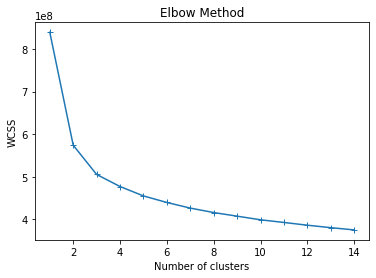

In [3]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(user_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss,marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow method : the optimal number is k=3

Verification with silhouette methode :

In [13]:
#NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s1 = silhouette_score(user_matrix, labels)
#s1

0.6710904937285531

In [14]:
# NE PAS RUN : tres tres long
#kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
#labels = kmeans.labels_
#s2 = silhouette_score(user_matrix, labels)
#s2

0.5245359402930275

Silhouette method actually gives 2

## Cluster sizes

In [70]:
def get_cluster_size(clustering, nb_clusters,matrix=user_matrix) :
    for k in range(nb_clusters):
        number_users_in_cluster = 0.
        for user_index in range(1,len(matrix)) :
            if kmeans.labels_[user_index]==k :
                number_users_in_cluster+=1
        print(number_users_in_cluster)

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 2)

19429.0
186779.0


In [8]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_matrix)
get_cluster_size(kmeans, 3)

167141.0
32179.0
6888.0


Clusters are very inequal, this clustering is not relevant.

## Clustering avec contrainte sur clusters size

In [65]:
import constrained_kmeans as cons

In [ ]:
#ne pas run : tres tres long
(C,M,f) = cons.constrained_kmeans(user_matrix, [92794,92794], maxiter=50)

Way too long to run (more than 6hours), never finished

## Dimensionnality reduction

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [5]:
user_matrix = np.array(user_matrix)

In [6]:
row_sums = user_matrix.sum(axis=1) #Normalize on the rows (rows_sum -> 1)
norm_matrix = user_matrix / row_sums[:, np.newaxis]
for (i, l) in enumerate(norm_matrix) :
    if str(l[0])=="nan":
        for k in range(0, len(norm_matrix[0])):
            norm_matrix[i][k]=0

In [51]:
pca = PCA(random_state=0) 
pca.fit(norm_matrix)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [80]:
reduc_matrix = pca.transform(user_matrix)

Determine the right number of dimensions as a trade-off between number of dimensions and loss of variance.

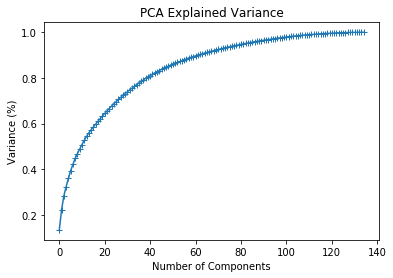

In [53]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='+')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.show()

dimension choosen at the elbow : dim=30

In [82]:
pca = PCA(n_components=30, random_state=0)
reduc_matrix = pca.fit_transform(norm_matrix)

In [81]:
reduc_matrix.shape

(206209, 30)

Understand the new dimension vectors by looking at the features impacting them the most

In [88]:
i=0
for d in pca.components_ :
    print("dimension" + str(i)+" ") 
    i+=1
    print(str(aisle_list[np.argmax(d)]) + " " + str(np.max(d)))
    print(str(aisle_list[np.argmin(d)])+" "+str(np.min(d)))

dimension0 
fresh vegetables 0.7076249915554522
water seltzer sparkling water -0.26314190077463284
dimension1 
fresh fruits 0.7533425977856487
fresh vegetables -0.5941949157714197
dimension2 
water seltzer sparkling water 0.931221598490975
yogurt -0.1696970786942593
dimension3 
packaged produce 0.7982154539962941
yogurt -0.5265294746109422
dimension4 
yogurt 0.7631546502389212
soft drinks -0.25109947868648586
dimension5 
packaged vegetables fruits 0.7993179622678135
soft drinks -0.4476198906443038
dimension6 
milk 0.7211703755630717
soft drinks -0.561658268990207
dimension7 
milk 0.5998370338124163
chips pretzels -0.12439548783948909
dimension8 
ice cream ice 0.8680504046854851
packaged cheese -0.24566961691811942
dimension9 
refrigerated 0.7799553135607814
ice cream ice -0.33119613000664627
dimension10 
chips pretzels 0.7043137176031647
frozen meals -0.4678305705929978
dimension11 
soy lactosefree 0.61176972053749
packaged cheese -0.47037814327232996
dimension12 
frozen meals 0.767203

Determine the right number of clusters (k)

In [ ]:
#un peu long
wcss=[]
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(reduc_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss, marker='+')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal k is 5 with this method

In [83]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(reduc_matrix)

In [84]:
get_cluster_size(kmeans, 5, reduc_matrix)

38233.0
55661.0
7932.0
5366.0
99016.0


That's better : 3 pretty big clusters and 2 small (2 et 3)

## Analyse the clusters

**Look at centroids distance**

In [83]:
kmeans.cluster_centers_

array([[ 1.96462852e+01, -7.22445965e+00,  3.84945336e+00,
         1.01861296e+01,  3.26425950e+00,  1.43241651e+00,
         2.62391920e+00,  2.93092207e+00,  5.09570264e+00,
         1.41536220e+00,  1.84469058e+00,  4.75059704e-01,
         1.50445094e+00,  9.47974683e-01,  2.01099566e+00,
         2.20662292e+00,  6.82523950e-01,  1.08201040e+00,
         4.51249100e-01,  1.44827452e+00,  1.88530390e+00,
        -4.16388837e-01,  3.64750174e-01,  1.55609720e+00,
         4.83390653e-01, -1.65298736e-01,  2.68829419e-01,
         7.28235891e-01,  2.93778594e-01,  9.22302267e-01],
       [ 4.52948847e+01,  6.24930640e+00,  6.10301466e+00,
         7.95002828e+00,  3.76284696e+00,  2.40037000e-01,
         4.24676606e+00,  4.05804983e+00,  6.17724816e+00,
         1.86208018e+00,  1.59423535e+00,  1.22522001e-01,
         2.14406369e+00,  1.20602270e+00,  1.52926247e+00,
         3.19586197e+00,  1.14459322e+00,  1.95575331e+00,
         5.73650211e-01,  1.99604862e+00,  2.11802006e+

In [58]:
def dist_centroids(clustering):
    k=len(clustering.cluster_centers_)
    distances = np.zeros((k,k))
    for x in range(k):
        for y in range(x):
            dist = np.linalg.norm(clustering.cluster_centers_[x]-clustering.cluster_centers_[y]) #calculate euclidian distance
            distances[x,y]=dist
    return distances

In [59]:
dist_centroids(kmeans)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.38580685, 0.        , 0.        , 0.        , 0.        ],
       [0.28055434, 0.157692  , 0.        , 0.        , 0.        ],
       [0.61677855, 0.51200915, 0.51487239, 0.        , 0.        ],
       [0.35856946, 0.3041038 , 0.22265987, 0.58301387, 0.        ]])

cluster 2 and 3 are pretty 'basic' : look to all others, and are alike. Probably has something to do with the fact they are the two small clusters.

**prepare df**

In [18]:
aisles = pd.read_csv('data/aisles.csv', sep=',')

In [23]:
#convert the matrix into df
matrix_df = pd.DataFrame(user_matrix, index = range(len(user_matrix)), columns = ['Null']+list(aisles.aisle) )
matrix_df = matrix_df.drop('Null', axis=1) #drop first useless column
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Add a column 'cluster'
matrix_df['cluster']=kmeans.labels_
matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Convert Normalized matrix into a df
norm_matrix_df = pd.DataFrame(norm_matrix, index = range(len(norm_matrix)), columns = ['Null']+list(aisles.aisle) )
norm_matrix_df = norm_matrix_df.drop('Null', axis=1) #drop first useless column
norm_matrix_df.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.005128,0.0,0.030769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.055556
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [85]:
#Add column 'cluster'
norm_matrix_df['cluster']=kmeans.labels_
norm_matrix_df.head()

NameError: name 'norm_matrix_df' is not defined

**Study the mean distribution of products per ailse in each clusters**

In [88]:
mean_clusters = norm_matrix_df.groupby(['cluster']).mean()
mean_clusters

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002347,0.002194,0.021286,0.005225,0.001063,0.000867,0.000677,0.000890,0.005037,0.000090,...,0.001253,0.000319,0.000449,0.004668,0.005737,0.005045,0.006310,0.000105,0.000276,0.000060
1,0.001617,0.002466,0.009317,0.003968,0.001461,0.000818,0.001072,0.000507,0.006103,0.000130,...,0.000426,0.000193,0.000134,0.006075,0.004102,0.004932,0.008643,0.000079,0.000234,0.000008
2,0.001808,0.001614,0.007971,0.003989,0.001272,0.001015,0.000780,0.001220,0.003873,0.000337,...,0.001322,0.000740,0.001615,0.003274,0.003831,0.002998,0.004400,0.000195,0.000875,0.000747
3,0.002034,0.002578,0.012487,0.005377,0.001822,0.000923,0.000960,0.000946,0.006620,0.000229,...,0.000866,0.000444,0.000784,0.005712,0.005197,0.004455,0.007977,0.000139,0.000417,0.000181
4,0.001752,0.002846,0.008930,0.003914,0.001773,0.000754,0.001112,0.000672,0.006509,0.000213,...,0.000339,0.000274,0.000313,0.005922,0.004223,0.004192,0.008624,0.000105,0.000252,0.000091


**Evaluate the features discrimining the clusters**

In [89]:
matrix_df.corr()['cluster'].sort_values(ascending=True)

yogurt                     -0.103890
baby food formula          -0.066338
energy granola bars        -0.045212
granola                    -0.028618
fruit vegetable snacks     -0.026792
                              ...   
spices seasonings           0.128570
canned jarred vegetables    0.154697
fresh herbs                 0.186832
fresh vegetables            0.303993
cluster                     1.000000
Name: cluster, Length: 135, dtype: float64

features influencing the most the cluster affiliation seem to be the 9 ones listed above 
_not convinced by the method_

In [90]:
array = norm_matrix_df.values
X = array[:,0:-1]
Y = array[:,-1]

In [91]:
scores = SelectKBest(chi2, k=20).fit(X, Y)

In [92]:
features = pd.DataFrame(index=norm_matrix_df.columns[:-1], data= scores.scores_, columns=["Score"]).sort_values("Score",ascending=False)
features.head(10)

,Score
fresh vegetables,6673.231411
fresh fruits,3593.022833
packaged vegetables fruits,1291.477993
yogurt,1247.247546
fresh herbs,605.045403
baby food formula,454.738648
packaged cheese,312.285344
frozen produce,199.160539
soft drinks,187.705210
canned jarred vegetables,184.739974


_better method_ most important features. Note that it is coherent with the features impacting the first dimensions

In [93]:
imp_features = features.head(10).index

In [94]:
mean_clusters[imp_features]

,fresh vegetables,fresh fruits,packaged vegetables fruits,yogurt,fresh herbs,baby food formula,packaged cheese,frozen produce,soft drinks,canned jarred vegetables
cluster,,,,,,,,,,
0,0.055234,0.171990,0.057199,0.084380,0.005759,0.022252,0.032092,0.014151,0.006626,0.004792
1,0.185342,0.161535,0.069457,0.041928,0.018915,0.014748,0.028731,0.016484,0.002517,0.010153
2,0.043196,0.056868,0.028669,0.021713,0.004908,0.003966,0.017202,0.009540,0.014235,0.004943
3,0.126640,0.134493,0.061953,0.045295,0.013106,0.009087,0.029738,0.016980,0.008248,0.009521
4,0.209975,0.129380,0.067404,0.031372,0.021455,0.007541,0.027036,0.017868,0.004220,0.012718


0 : bcp de fresh fruits ; peu de soft drinks

1 : tres peu de packaged ; bcp de fresh vegetables  ; peu de soft drinks ; bcp herbs

2 : bcp de packaged ; peu d'herbs ; peu ice cream

3 :  bcp de sparkling water ; peu de fresh fruits ; peu de pack veg fruits ; bcp paper

4 : tres peu de packaged ; peu de fresh fruits ; peu de pack veg fruits ; bcp frozen meals ; bcp paper ; plus ice cream

classification healthiness : 1>0 (bons)  >  (mauvais) 3>2>4

## Vizualisation 

No handles with labels found to put in legend.


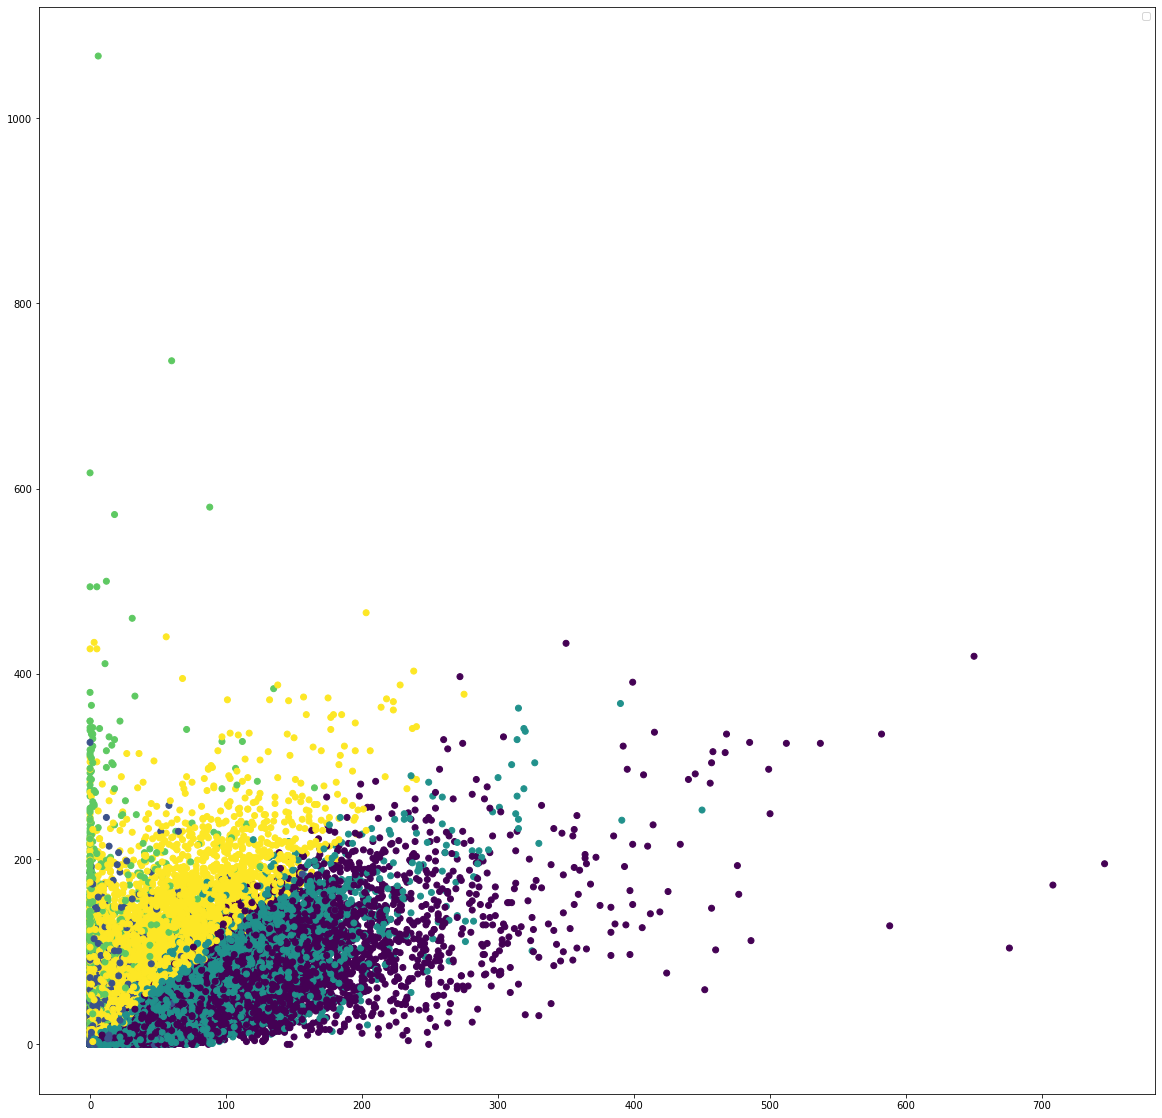

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(matrix_df['fresh vegetables'], matrix_df['fresh fruits'], c=matrix_df['cluster'], cmap='viridis')
#centers = kmeans.cluster_centers_
#plt.scatter(centers['fresh_vegetables'], centers['fresh_fruits'], c='black', alpha=0.5);

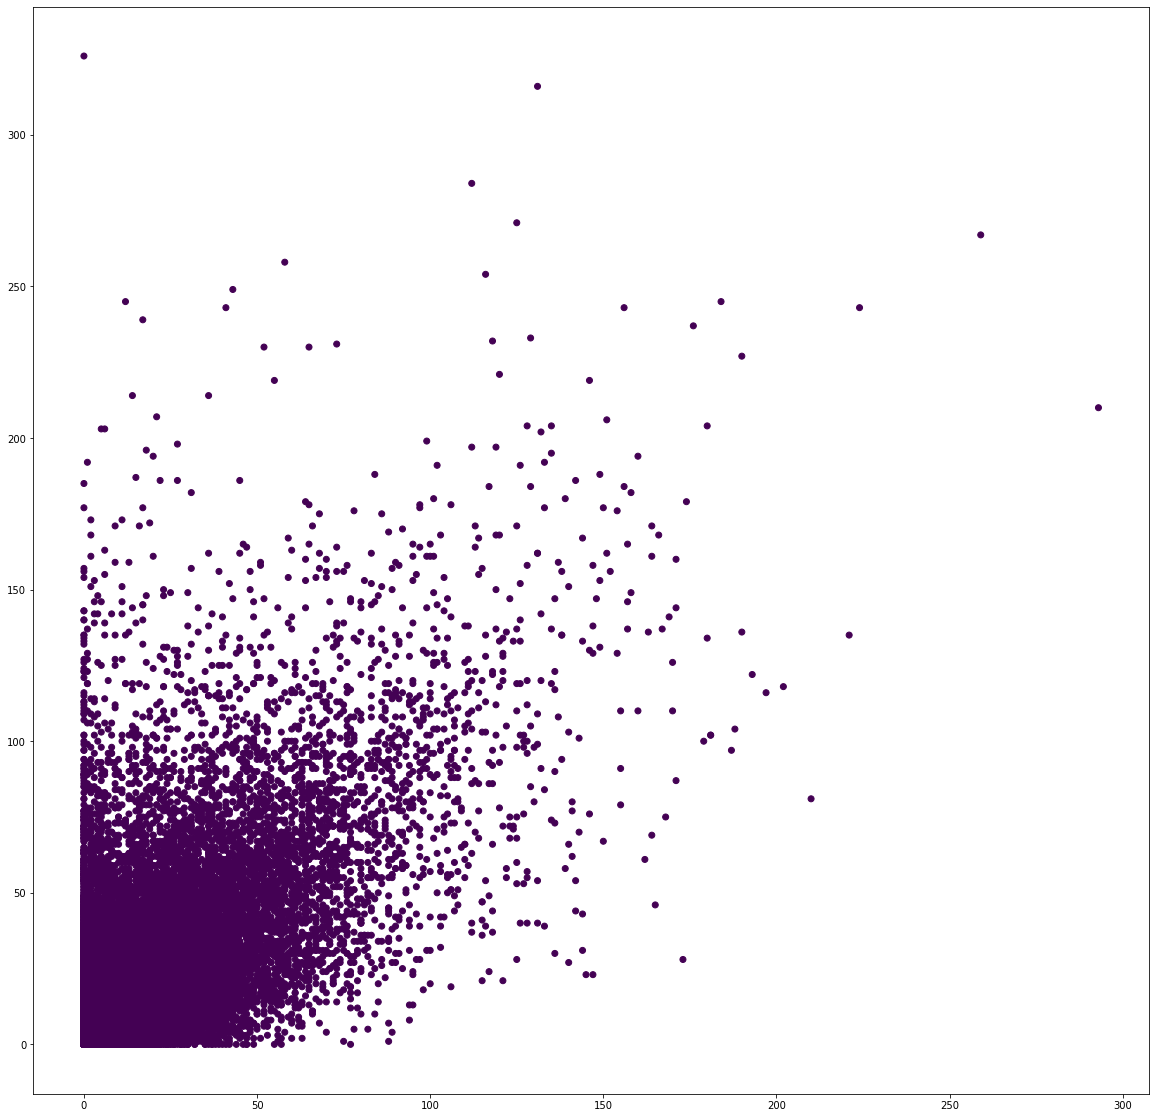

In [39]:
fig, ax = plt.subplots(figsize=(20,20))
dessin = matrix_df[matrix_df.cluster ==4  ]
ax.scatter(dessin['fresh vegetables'], dessin['fresh fruits'], c=dessin['cluster'], cmap='viridis')

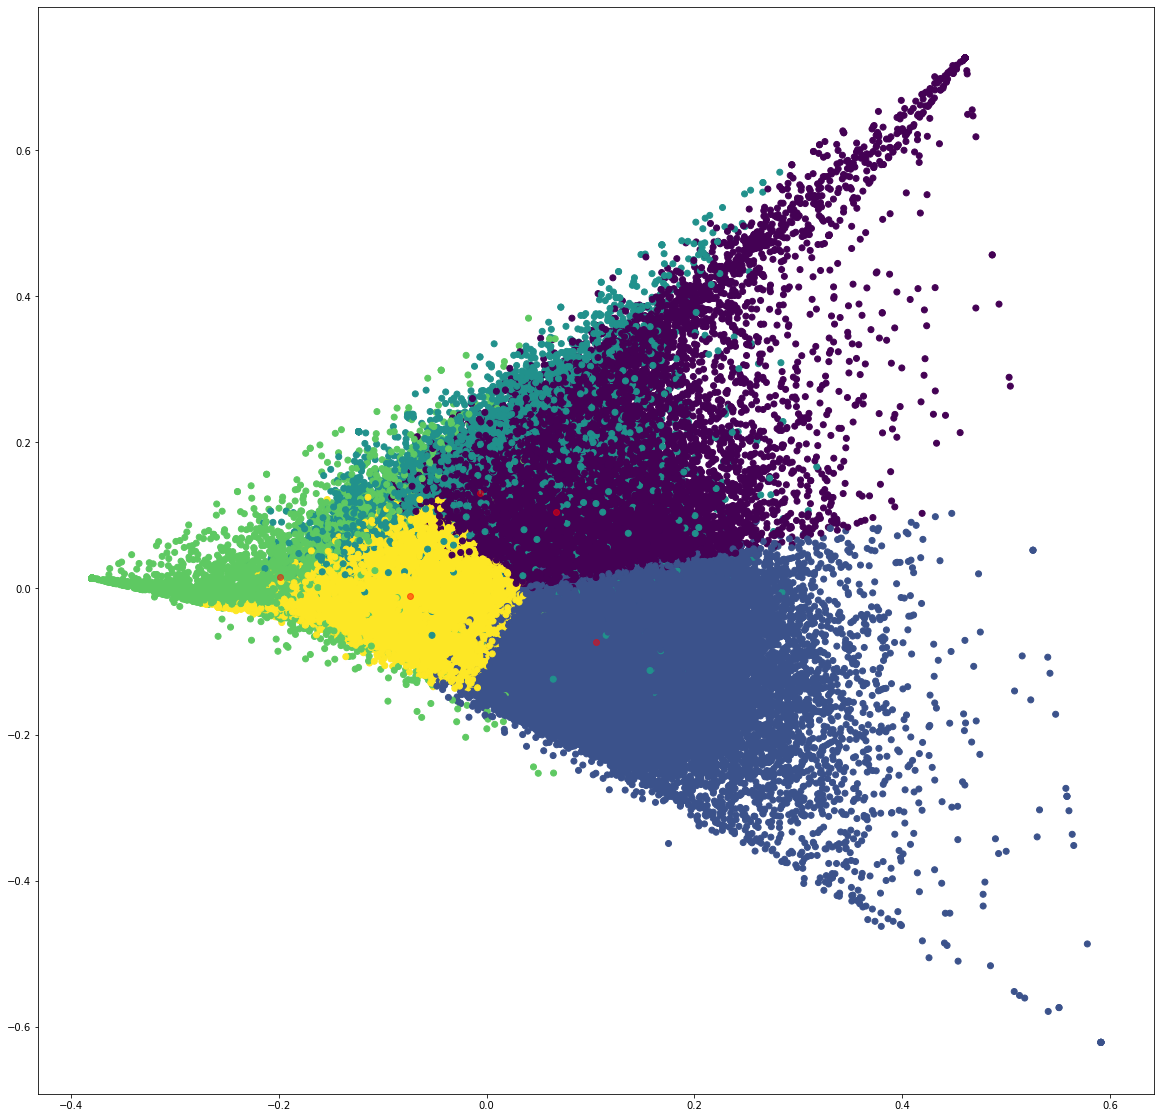

In [87]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(reduc_matrix[:,0], reduc_matrix[:,1], c=kmeans.labels_, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter(centers[:,0], centers[:,1], c='red', alpha=0.5);

In [80]:
user_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Habits

In [30]:
def stats_cluster(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]

    # Timing of orders
    print (orders[orders.user_id.isin(user)].groupby('order_id').mean().describe())

In [31]:
stats_cluster(0)

             user_id   order_number      order_dow  order_hour_of_day  \
count  635446.000000  635446.000000  635446.000000      635446.000000   
mean   103200.993453      17.309128       2.780628          13.450134   
std     59238.774067      17.929014       2.047034           4.224018   
min         1.000000       1.000000       0.000000           0.000000   
25%     51657.000000       5.000000       1.000000          10.000000   
50%    103268.000000      11.000000       3.000000          13.000000   
75%    154334.000000      24.000000       5.000000          16.000000   
max    206201.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           597213.000000  
mean                11.051282  
std                  9.192371  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [32]:
stats_cluster(1)

             user_id   order_number      order_dow  order_hour_of_day  \
count  922246.000000  922246.000000  922246.000000      922246.000000   
mean   102575.428146      17.169224       2.777506          13.449460   
std     59515.351371      17.785143       2.047414           4.226912   
min         4.000000       1.000000       0.000000           0.000000   
25%     50792.000000       5.000000       1.000000          10.000000   
50%    102070.000000      11.000000       3.000000          13.000000   
75%    154080.000000      23.000000       5.000000          16.000000   
max    206202.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           866585.000000  
mean                11.124271  
std                  9.215804  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [33]:
stats_cluster(2)

             user_id   order_number      order_dow  order_hour_of_day  \
count  132012.000000  132012.000000  132012.000000      132012.000000   
mean   103931.318797      17.236789       2.773149          13.413750   
std     59734.206598      17.841536       2.044730           4.222624   
min        51.000000       1.000000       0.000000           0.000000   
25%     52683.000000       5.000000       1.000000          10.000000   
50%    103807.000000      11.000000       3.000000          13.000000   
75%    155402.000000      23.000000       5.000000          16.000000   
max    206141.000000     100.000000       6.000000          23.000000   

       days_since_prior_order  
count           124080.000000  
mean                11.147695  
std                  9.228813  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [34]:
stats_cluster(3)

             user_id  order_number     order_dow  order_hour_of_day  \
count   88126.000000  88126.000000  88126.000000       88126.000000   
mean   103535.934174     17.117922      2.792933          13.453249   
std     59786.692922     17.948948      2.048201           4.240662   
min        29.000000      1.000000      0.000000           0.000000   
25%     51701.000000      5.000000      1.000000          10.000000   
50%    103824.000000     11.000000      3.000000          13.000000   
75%    153856.000000     23.000000      5.000000          16.000000   
max    206170.000000    100.000000      6.000000          23.000000   

       days_since_prior_order  
count            82760.000000  
mean                11.106187  
std                  9.230581  
min                  0.000000  
25%                  4.000000  
50%                  7.000000  
75%                 15.000000  
max                 30.000000  


In [35]:
stats_cluster(4)

            user_id  order_number     order_dow  order_hour_of_day  \
count  1.643239e+06  1.643239e+06  1.643239e+06       1.643239e+06   
mean   1.030108e+05  1.708262e+01  2.773140e+00       1.345718e+01   
std    5.962587e+04  1.760661e+01  2.046513e+00       4.225920e+00   
min    3.000000e+00  1.000000e+00  0.000000e+00       0.000000e+00   
25%    5.149300e+04  5.000000e+00  1.000000e+00       1.000000e+01   
50%    1.026360e+05  1.100000e+01  3.000000e+00       1.300000e+01   
75%    1.544460e+05  2.300000e+01  5.000000e+00       1.600000e+01   
max    2.062080e+05  1.000000e+02  6.000000e+00       2.300000e+01   

       days_since_prior_order  
count            1.544223e+06  
mean             1.113188e+01  
std              9.204006e+00  
min              0.000000e+00  
25%              4.000000e+00  
50%              7.000000e+00  
75%              1.500000e+01  
max              3.000000e+01  


Bon le seum, rien d'interessant en terme de jour et heure de commande, nb de commande, et date de la derniere commande...

In [40]:
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
def orders_qte(nb_cluster):
    user = matrix_df.index[matrix_df.cluster==nb_cluster]
    order_cluster = orders[orders.user_id.isin(user)].order_id
    print(history[history.order_id.isin(order_cluster)].groupby('order_id').count().mean())

In [15]:
orders_qte(0)

product_id           10.074077
add_to_cart_order    10.074077
reordered            10.074077
dtype: float64


In [16]:
orders_qte(1)

product_id           10.125314
add_to_cart_order    10.125314
reordered            10.125314
dtype: float64


In [17]:
orders_qte(2)

product_id           10.103707
add_to_cart_order    10.103707
reordered            10.103707
dtype: float64


In [18]:
orders_qte(3)

product_id           10.04658
add_to_cart_order    10.04658
reordered            10.04658
dtype: float64


In [ ]:
orders_qte(4)

Nothing interesing about the nb of products per order

## Client fidelity and ranking of products

In [3]:
import pickle
f=open("history_small","rb")
history_small = pickle.load(f)
f.close()

In [4]:
consumptions = pd.merge(history_small, orders, on="order_id")
consumptions["product_id_bis"]=consumptions["product_id"]

In [5]:
consumptions.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id_bis
0,2,33120,1,1,202279,prior,3,5,9,8.0,33120
1,2,28985,2,1,202279,prior,3,5,9,8.0,28985
2,2,9327,3,0,202279,prior,3,5,9,8.0,9327
3,2,45918,4,1,202279,prior,3,5,9,8.0,45918
4,2,30035,5,0,202279,prior,3,5,9,8.0,30035


#### Fidelity = number of times each user re-bought each product

In [6]:
fidelity = consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum","product_id_bis" :"mean"})

#### Fidelity_per_user = number of times each user re-bought a product, on average

In [7]:
fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'}).rename(columns={"reordered": "user_fidelity"})
fidelity_per_user_notnull = fidelity_per_user[fidelity_per_user.user_fidelity>0]
fidelity_per_user_notnull.sort_values("user_fidelity").head()

,user_fidelity
user_id,
170452,0.012658
55086,0.020000
129873,0.020000
56718,0.020000
126770,0.021277


#### Satisfaction_per_product = number of times each product is re-bought by users, on average

In [8]:
satisfaction_per_product = fidelity.groupby("product_id").agg({'reordered':'mean'}).rename(columns={"reordered": "satisfaction_per_product"})

In [9]:
satisfaction_per_product.sort_values("satisfaction_per_product").tail()

,satisfaction_per_product
product_id,
25593,5.500000
21482,6.000000
12995,6.666667
12981,7.000000
19675,8.000000


#### Product_quality = how users like the product (weighted average over user fidelity)

In [10]:
with_user_fidelity = pd.merge(fidelity, fidelity_per_user_notnull, on="user_id")
with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity

In [11]:
quality_per_product = with_user_fidelity.groupby("product_id_bis").agg({"appreciation_per_user":"mean"})

In [12]:
quality_per_product.sort_values("appreciation_per_user").tail()

,appreciation_per_user
product_id_bis,
39746,10.840064
25135,11.333333
32612,15.250000
16424,19.000000
36433,19.302239


In [13]:
quality_per_product["count"]=1
quality_per_product["appreciation_per_user"]=round(quality_per_product["appreciation_per_user"],2)
distribution_qualities = quality_per_product.groupby("appreciation_per_user").agg({"count":"sum"})

Text(0.5, 1.0, 'User appreciation distribution')

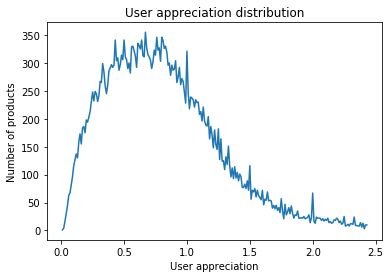

In [14]:
Y = list(distribution_qualities.values)
X = list(distribution_qualities.index)
l = round(len(Y)/2)
plt.plot(X[1:l],Y[1:l])
plt.xlabel("User appreciation")
plt.ylabel("Number of products")
plt.title("User appreciation distribution")

Left-skewed distribution, with average 1 by definition (we normalized by user enthousiasm).

#### Now let's try to get a "satisfaction score" for each aisle

We might think about averaging the scores, but some of them may be undefined, and some products might be much more consumed than others.

In [15]:
# Weight given to each product = number of times it was bought
consumptions["count_consumptions"] = 1
product_weights = consumptions.groupby("product_id").agg({"count_consumptions":"sum"})

In [16]:
# Columns of qualities_and_weights : product_id || score of the product || number of times it was bought
quality_per_product["product_id"] = quality_per_product.index
qualities_and_weights = pd.merge(product_weights, quality_per_product, on="product_id")

# qualities_joined links the previous dataset with data about products (aisle, department...)
qualities_joined = pd.merge(qualities_and_weights, products, on="product_id")
qualities_joined["sum_appreciations"]=qualities_joined.appreciation_per_user * qualities_joined.count_consumptions

In [17]:
qualities_joined.head()

,product_id,count_consumptions,appreciation_per_user,count,product_name,aisle_id,department_id,sum_appreciations
0,1,290,0.72,1,Chocolate Sandwich Cookies,61,19,208.80
1,2,14,0.10,1,All-Seasons Salt,104,13,1.40
2,3,27,1.54,1,Robust Golden Unsweetened Oolong Tea,94,7,41.58
3,4,46,0.74,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,34.04
4,5,2,1.06,1,Green Chile Anytime Sauce,5,13,2.12


In [20]:
# Quality of an aisle = weighted average of scores of its products

# Group by aisle remembering sum of scores and total weight
aisle_avg_quality = qualities_joined.groupby("aisle_id").agg({"count_consumptions":"sum","sum_appreciations":"sum"})

# Make a smart division to obtain weighted average
aisle_avg_quality["aisle_score"] = aisle_avg_quality.sum_appreciations / aisle_avg_quality.count_consumptions

# Put the name of the aisle with previous data
aisle_avg_quality = pd.merge(aisle_avg_quality[["aisle_score","count_consumptions"]], aisles, on="aisle_id")

The score is difficult to interpret. Nevertheless, a score bigger than 1 means that the majority of products bought in the aisle are more often re-consumed than the overall average. The smaller the score, the less often consumers tend to re-buy the products of the aisle.

The column "count_consumptions" may be considered as the reilabilit of the score. The smaller, the less orders were made from this aisle, the more an outlier consumer can biase the score.

In [45]:
# Aisles that contain most "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").tail(50)

,aisle_id,aisle_score,count_consumptions,aisle
127,128,0.919202,29900,tortillas flat bread
53,54,0.919672,37377,paper goods
49,50,0.920789,27271,fruit vegetable snacks
6,7,0.930176,5069,packaged meat
124,125,0.930303,5542,trail mix snack mix
56,57,0.934326,16123,granola
47,48,0.950905,11291,breakfast bars pastries
41,42,0.955150,15560,frozen vegan vegetarian
105,106,0.956703,46845,hot dogs bacon sausage
70,71,0.959261,5818,refrigerated pudding desserts


In [22]:
# Aisles that contain least "fidelizing products"
aisle_avg_quality.sort_values(by="aisle_score").head(20)

,aisle_id,aisle_score,count_consumptions,aisle
103,104,0.205615,32517,spices seasonings
96,97,0.262158,3633,baking supplies decor
9,10,0.309093,1423,kitchen supplies
117,118,0.316934,1598,first aid
108,109,0.336119,1577,skin care
131,132,0.341176,952,beauty
84,85,0.355026,10243,food storage
21,22,0.362906,4935,hair care
43,44,0.368390,1354,eye ear care
79,80,0.378716,2290,deodorants


### Get scores per cluster

In [55]:
# load the mean of clusters when clustering is done with k=5
f= open("mean_clusters","rb")
mean_clusters=pickle.load(f)
f.close()

array_clusters = np.array(mean_clusters)
columns = list(mean_clusters.columns)
aisle_scores =np.array(aisle_avg_quality[["aisle_score","aisle"]])

In [62]:
aisle_names = list(mean_clusters.columns)

def aisle_name_to_id(aisle_name):
    for k in range(len(aisles)):
        if aisles.values[k][1]==aisle_name :
            return k+1
    return 1/0

def id_to_aisle_name(aisle_id):
    return aisles.values[aisle_id-1][1]

def sort_scores(scores, aisle_names):
    s = np.zeros(len(scores))
    for k in range(0, len(scores)):
        score, aisle_name = scores[k][0], scores[k][1]
        aisle_id = aisle_name_to_id(aisle_name)
        s[aisle_id-1] = score
        print(k,"becomes",aisle_id-1)
    return s

In [59]:
array_clusters.dot(sc)

array([1.21522882, 0.41642046, 1.07867858, 1.29963026, 1.04952072])